In [4]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import shap

# Automatically add the project root (1 level up) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import preprocessor, VandalismScorer

In [3]:
df = pd.read_csv(project_root+"/Data/train.csv")
preprocessor(df)

In [16]:
def train(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv: StratifiedKFold,
    scoring: str = "accuracy",
) -> None:

    baseline_model = Pipeline([('scorer', VandalismScorer()), ('xgb', xgb.XGBClassifier(random_state=42))])
    baseline_score = cross_val_score(
        baseline_model, predictor, target, cv=cv, scoring=scoring
    ).mean()
    print(f"Baseline {scoring} score: {baseline_score:.4f}")

    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "random_state": 42,
        }

        model = Pipeline([('scorer', VandalismScorer()), ('xgb', xgb.XGBClassifier(**params))])
        score = cross_val_score(model, predictor, target, cv=cv, scoring=scoring).mean()

        return score

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=25)

    print("Optuna Optimization Results")
    print("Best Accuracy:", study.best_value)
    print("Best hyperparameters:", study.best_params)

    return study.best_params, study.best_value


def shap_rfe(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv,
    scoring: str = "accuracy",
    drop_threshold: float = 0.01,
    min_features: int = 1,
) -> tuple[float, list[str]]:
    features = predictor.columns.tolist()
    model = Pipeline([('scorer', VandalismScorer()), ('xgb', xgb.XGBClassifier(random_state=42, verbosity=0))])
    initial_score = cross_val_score(
        model, predictor, target, cv=cv, scoring=scoring
    ).mean()

    performance = [(len(features), initial_score)]
    print(f"Start: {len(features)} features → {scoring}: {initial_score:.4f}")

    best_score = initial_score
    best_features = features.copy()

    while len(features) > min_features:
        model = xgb.XGBClassifier(random_state=42, verbosity=0)
        model.fit(predictor[features], target)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(predictor[features])

        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({"feature": features, "mean_shap": mean_shap})
        shap_df = shap_df.sort_values(by="mean_shap")

        feature_to_drop = shap_df.iloc[0]["feature"]
        features.remove(feature_to_drop)

        score = cross_val_score(
            xgb.XGBClassifier(random_state=42, verbosity=0),
            predictor[features],
            target,
            cv=cv,
            scoring=scoring,
        ).mean()

        if score > best_score:
            best_score = score
            best_features = features.copy()

        performance.append((len(features), score))

        if best_score - score > drop_threshold:
            break

    lengths, scores = zip(*performance)
    plt.figure(figsize=(10, 6))
    plt.plot(lengths, scores, marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(scoring.capitalize())
    plt.title("RFE Performance vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()

    return best_score, best_features

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target = "isvandalism"

In [18]:
features_1 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "EditID",
    "added_lines",
    "deleted_lines"
]

best_params, best_score = train(df[features_1], df[target], cv)

Baseline accuracy score: 0.9127
Optuna Optimization Results
Best Accuracy: 0.9161163407290378
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 1.9024978934955494, 'subsample': 0.7359660928342937, 'colsample_bytree': 0.8765862797052864, 'colsample_bylevel': 0.8791472442402003, 'reg_alpha': 1.8456128259583087, 'learning_rate': 0.056462992736512986, 'n_estimators': 760}


## Older code (has not been re-run with VandalismScorer() pipeline)

In [ ]:
cols_to_transform = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
]

for col in cols_to_transform:
    df[f"log_{col}"] = np.log1p(df[col])

features_2 = [
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
    "EditID",
    "added_lines",
    "deleted_lines"
]

best_params, best_score = train(df[features_2], df[target], cv)

Baseline accuracy score: 0.9245
Optuna Optimization Results
Best Accuracy: 0.9270490996357248
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 3.141595241599972, 'subsample': 0.818585447494315, 'colsample_bytree': 0.7643301466688923, 'colsample_bylevel': 0.9834643450676969, 'reg_alpha': 0.3358100247796204, 'learning_rate': 0.0805746634624542, 'n_estimators': 916}


In [ ]:
features_3 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
    "EditID",
    "added_lines",
    "deleted_lines"
]

best_params, best_score = train(df[features_3], df[target], cv)

Baseline accuracy score: 0.9225
Optuna Optimization Results
Best Accuracy: 0.9272852579680624
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.37730678446601834, 'subsample': 0.8799941705248336, 'colsample_bytree': 0.9666039231269101, 'colsample_bylevel': 0.8974341267150372, 'reg_alpha': 2.9678231951953236, 'learning_rate': 0.048585930704550404, 'n_estimators': 566}


Original Features:
Start: 14 features → accuracy: 0.9234


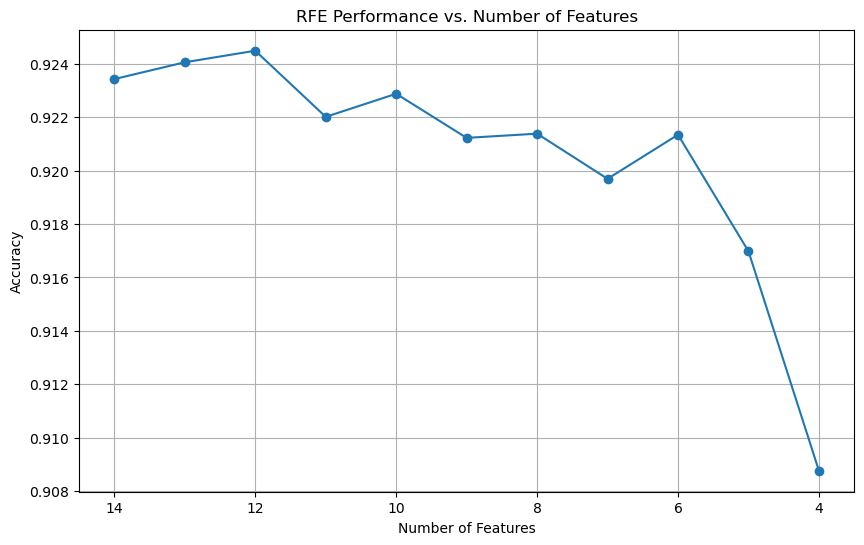


Transformed Features:
Start: 14 features → accuracy: 0.9245


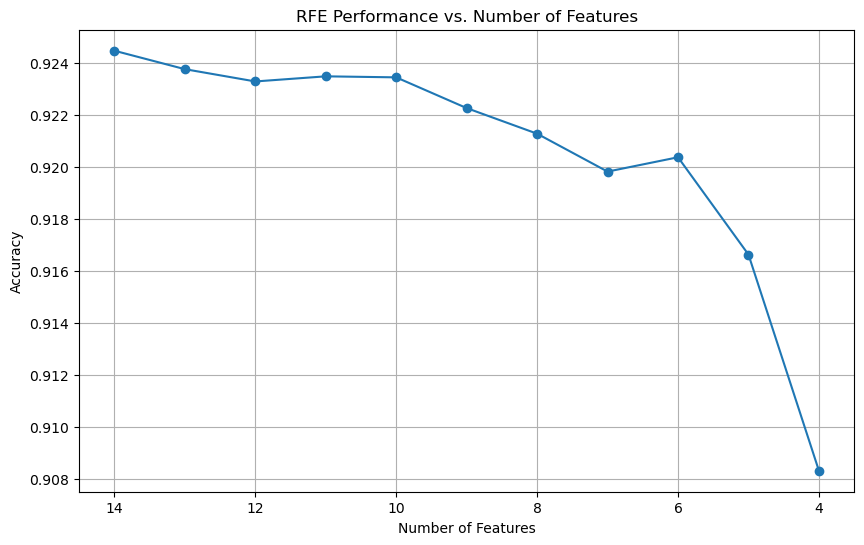


Combined Features:
Start: 23 features → accuracy: 0.9225


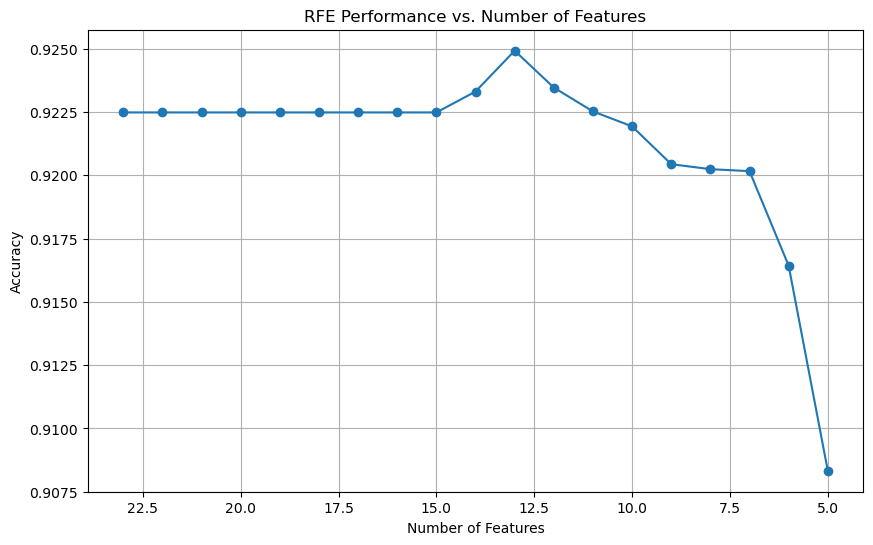

In [8]:
print("Original Features:")
best_score_1, best_features_1 = shap_rfe(df[features_1], df[target], cv)

print("\nTransformed Features:")
best_score_2, best_features_2 = shap_rfe(df[features_2], df[target], cv)

print("\nCombined Features:")
best_score_3, best_features_3 = shap_rfe(df[features_3], df[target], cv)

In [9]:
print("Original features:")
print(f"features: {best_features_1}")
print(f"performance: {best_score_1}")

print("\nTransformed features:")
print(f"features: {best_features_2}")
print(f"performance: {best_score_2}")

print("\nCombined features:")
print(f"features: {best_features_3}")
print(f"performance: {best_score_3}")

Original features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'is_person']
performance: 0.9244929319925405

Transformed features:
features: ['vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'is_person', 'log_user_edit_count', 'log_user_distinct_pages', 'log_user_warns', 'log_num_recent_edits', 'log_num_recent_reversions', 'log_num_edits_5d_before', 'log_account_age', 'log_word_count_added', 'log_word_count_deleted']
performance: 0.9244535696927304

Combined features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'log_user_edit_count']
performance: 0.9249256543595681


In [10]:
print("Original features:")
train_params_1, best_score_1 = train(
    df[best_features_1], df[target], cv, scoring="accuracy"
)

print("\nTransformed features:")
train_params_2, best_score_2 = train(
    df[best_features_2], df[target], cv, scoring="accuracy"
)

print("\nCombined features:")
train_params_3, best_score_3 = train(
    df[best_features_3], df[target], cv, scoring="accuracy"
)

Original features:
Baseline accuracy score: 0.9245
Optuna Optimization Results
Best Accuracy: 0.9266558323676424
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 2.6365802330446995, 'subsample': 0.8027883410092592, 'colsample_bytree': 0.9892518341476984, 'colsample_bylevel': 0.6992742978040835, 'reg_alpha': 0.4195802318106978, 'learning_rate': 0.03191555692643836, 'n_estimators': 886}

Transformed features:
Baseline accuracy score: 0.9245
Optuna Optimization Results
Best Accuracy: 0.9267345337674786
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 3.574906090396237, 'subsample': 0.6413166189046338, 'colsample_bytree': 0.8364125062735576, 'colsample_bylevel': 0.7876749416699214, 'reg_alpha': 0.018528602300072756, 'learning_rate': 0.04242271315487732, 'n_estimators': 824}

Combined features:
Baseline accuracy score: 0.9249
Optuna Optimization Results
Best Accuracy: 0.9269705219680686
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1,